In [2]:
import osmnx as ox
import numpy as np
import pandas as pd
from rapidfuzz import process
import time
import geocoder
from geopy.exc import GeocoderTimedOut

import networkx as nx
import osmnx as ox
from pyrosm import OSM

%matplotlib inline
ox.__version__

import pickle

import geopandas as gpd
import folium 

import warnings
warnings.filterwarnings('ignore')

C:\Users\Giorgio\anaconda3\envs\myenv\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def calculate_mean_coordinate(row):
    #m = MultiLineString()
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    return (y, x)

def carica_dati_comuni(geojson_file):
    #comuni https://github.com/openpolis/geojson-italy
    #geojson_file = r"data\limits_IT_municipalities.geojson"
    comuni = gpd.read_file(geojson_file)
    comuni = comuni[['name', 'prov_name', 'reg_name', 'geometry']]
    #calcolo area comuni
    for_area = comuni.copy()
    for_area = for_area.to_crs({'init': 'epsg:32633'})
    comuni['area'] = (for_area['geometry'].area/ 10**6).round(4)
    return comuni

def carica_dati_province(geojson_file):
    #province
    #geojson_file = r"data\limits_IT_provinces.geojson"
    province = gpd.read_file(geojson_file)
    province = province[['prov_name', 'reg_name', 'geometry']]
    #calcolo area comuni
    for_area = province.copy()
    for_area = for_area.to_crs({'init': 'epsg:32633'})
    province['area'] = (for_area['geometry'].area/ 10**6).round(4)
    return province

def get_aggregazione_comuni_con_filtro(searchfor, lower_opt=False):
    networks = ['network_NE', 'network_NO', 'network_C', 'network_NE', 'network_I', 'network_S']
    #searchfor = ['Pietro Nenni', 'Giorgio Amendola', 'Ugo La Malfa', "Alcide De Gasperi", 'Ugo la Malfa', "Alcide de Gasperi",
    #            "Meuccio Ruini", "Alessandro Casati"]

    total_comuni_grouped = pd.DataFrame(columns=["comune", 'prov_name', 'reg_name', "n_filtrate", "n_streets"])
    for network in networks:
        streets = pd.read_pickle("./"+network+".pkl") 
        streets = streets[['name','geometry', 'length']]
        streets['mean_coordinate'] = streets.apply(calculate_mean_coordinate, axis=1)
        if lower_opt:
            streets['filter'] = streets['name'].str.lower().str.contains('|'.join(searchfor))
        else:
            streets['filter'] = streets['name'].str.contains('|'.join(searchfor))
        #faccio diventare mean_coordinate un geometry
        gdf_streets = gpd.GeoDataFrame(streets,  geometry=gpd.points_from_xy(streets.mean_coordinate.str[1], streets.mean_coordinate.str[0]))
        #metto in join con i comuni sulla base dell'appartenza geografica 
        sjoined_streets = gpd.sjoin(gdf_streets, comuni, predicate="within")
        #levo i duplicati delle strade dovute alle biforcazioni
        sjoined_streets = sjoined_streets.sort_values(['length'], ascending=False)
        sjoined_streets = sjoined_streets.drop_duplicates(subset=['name_left', 'name_right', 'prov_name','reg_name'], keep='first')
        #sjoined_streets
        comuni_grouped = sjoined_streets.groupby(['name_right', 'prov_name', 'reg_name'])['filter'].agg(['sum','count']).reset_index()
        comuni_grouped.columns = ["comune", 'prov_name', 'reg_name', "n_filtrate", "n_streets"]
        #comuni_grouped
        total_comuni_grouped = pd.concat([total_comuni_grouped, comuni_grouped]).reset_index(drop=True)
    return total_comuni_grouped

def calcola_metriche_comuni_in_gdp(total_comuni_grouped, comuni):
    vie_per_comune = comuni.merge(total_comuni_grouped, left_on=['name', 'prov_name', 'reg_name'], right_on=['comune', 'prov_name', 'reg_name'], how="left")
    #vie_per_comune['listings_count'] = vie_per_comune['listings_count'].fillna(0)
    # vie_per_comune
    gpd_geo_comuni = vie_per_comune[["name", "prov_name", "reg_name", "geometry", "area", "n_filtrate", "n_streets"]]
    gpd_geo_comuni["n_streets-over-area"] = (gpd_geo_comuni["n_streets"] / gpd_geo_comuni["area"]).astype(float).round(4)
    gpd_geo_comuni["n_filtrate-over-area"] = (gpd_geo_comuni["n_filtrate"] / gpd_geo_comuni["area"]).astype(float).round(4)
    gpd_geo_comuni["n_filtrate-over-n_streets"] = (gpd_geo_comuni["n_filtrate"]*100 / gpd_geo_comuni["n_streets"]).astype(float).round(4)
    
    gpd_geo_comuni.columns = ['Comune', 'Provincia', 'Regione', 'geometry', 'Superficie', 
                            'Vie di interesse', 'Vie totali', 'Vie per km^2', 
                            'Vie per di interesse km^2', 'Percentuale vie di interesse']
    return gpd_geo_comuni, vie_per_comune

def calcola_metriche_province_in_gdp(vie_per_comune, province):
    vie_per_provincia = vie_per_comune.groupby(['prov_name', 'reg_name'])['n_filtrate', 'n_streets'].apply(lambda x : x.sum()).reset_index()
    #vie_per_provincia
    gpd_geo_province = pd.merge(vie_per_provincia, province,  how='right', left_on=['prov_name','reg_name'], right_on = ['prov_name','reg_name'])
    gpd_geo_province = gpd_geo_province[["prov_name", "reg_name", "geometry", "area", "n_filtrate", "n_streets"]]
    gpd_geo_province["n_streets-over-area"] = (gpd_geo_province["n_streets"] / gpd_geo_province["area"]).astype(float).round(4)
    gpd_geo_province["n_filtrate-over-area"] = (gpd_geo_province["n_filtrate"] / gpd_geo_province["area"]).astype(float).round(4)
    gpd_geo_province["n_filtrate-over-n_streets"] = (gpd_geo_province["n_filtrate"]*100 / gpd_geo_province["n_streets"]).astype(float).round(4)
    gpd_geo_province.columns = ['Provincia', 'Regione', 'geometry', 'Superficie', 
                            'Vie di interesse', 'Vie totali', 'Vie per km^2', 
                            'Vie per di interesse km^2', 'Percentuale vie di interesse']
    gpd_geo_province = gpd.GeoDataFrame(gpd_geo_province)
    return gpd_geo_province, vie_per_provincia

def ottieni_grafico(gpd_geo_province, descrizione, metrica, cmap="RdPu"):
    #colori gradazione intensità https://matplotlib.org/stable/tutorials/colors/colormaps.html
    m = gpd_geo_province.explore(metrica, cmap=cmap, 
                                 tiles="CartoDB positron",
                                 width = 900, height = 800,
                                 zoom_start=6,
                                )

    # https://stackoverflow.com/questions/74267926/folium-map-title-disappearing-when-activating-fullscreen-mode
    from branca.element import Template, MacroElement
    template = """
    {% macro html(this, kwargs) %}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
      <title>Densità Toponomastica</title>
      <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">
    </head>

    <body>
    <div id='maplegend' class='maplegend' 
        style='position: absolute; z-index:9999; border:3px solid grey; background-color:rgba(255, 255, 255, 0.7);
        border-radius:6px; padding: 8px; font-size:18px; bottom: 3%; left: 1%; width: 25%'>

    <div class='title-box'>
    <div class='main-title'>Densità toponomastica provinciale</div>
    <div class='subtitle'>"""+descrizione+"""</div>

    <style type='text/css'>
      .title-box .main-title {
        text-align: left;
        margin-bottom: 8px;
        font-weight: bold;
        font-size: 100%;
        }
      .title-box .subtitle {
        text-align: left;
        margin-bottom: 8px;
        font-weight: normal;
        font-size: 75%;
        }
    </style>
    </body>

    {% endmacro %}"""

    macro = MacroElement()
    macro._template = Template(template)
    m.get_root().add_child(macro)
    return m



In [4]:
'''
from html2image import Html2Image
hti = Html2Image()
hti.screenshot(
    html_file='province_resistenza.html', save_as='province_resistenza.png',
    size=(1920, 1080)
)
'''

"\nfrom html2image import Html2Image\nhti = Html2Image()\nhti.screenshot(\n    html_file='province_resistenza.html', save_as='province_resistenza.png',\n    size=(1920, 1080)\n)\n"

In [6]:
geojson_comuni = r"data\limits_IT_municipalities.geojson"
geojson_province = r"data\limits_IT_provinces.geojson"

comuni = carica_dati_comuni(geojson_comuni)
province = carica_dati_province(geojson_province)

In [ ]:
#https://dait.interno.gov.it/territorio-e-autonomie-locali/sut/elenco_cens_var_comuni_italiani.php
lista_comuni=pd.read_excel(r"data\Elenco-comuni-italiani.xls", index_col=0)  
lista_comuni=lista_comuni[['Denominazione in italiano','Denominazione Regione']]
lista_comuni.columns=['comune','regione']
#lista_comuni.regione = lista_comuni.regione.str.replace("Valle d'Aosta/Vallée d'Aoste", "Valle d'Aosta")
#lista_comuni.regione = lista_comuni.regione.str.replace("Trentino-Alto Adige/Südtirol", "Trentino-Alto Adige")
lista_comuni['comune_low']=lista_comuni['comune'].str.lower()
lista_comuni.set_index('comune_low',inplace=True)
lista_comuni

popolazione_comuni=pd.read_excel(r"data\popolazione_comuni.xlsx", index_col=0)  
popolazione_comuni=popolazione_comuni[['DESCRIZIONE COMUNE', 'POPOLAZIONE CENSITA TOTALE']]
popolazione_comuni.columns=['comune','popolazione']
popolazione_comuni['comune_low']=popolazione_comuni['comune'].str.lower()
popolazione_comuni.set_index('comune_low',inplace=True)
popolazione_comuni

com_reg_pop = popolazione_comuni[['popolazione']].merge(lista_comuni, how='inner', left_index=True, right_index=True)
com_reg_pop = com_reg_pop.sort_values(by=['regione','popolazione'], ascending=False).reset_index()
com_reg_pop

In [ ]:
regioni = list(lista_comuni.regione.unique())
min_pop_cumuni = 10000
cross_regioni = {}
for regione in regioni:
    lista_comuni_10k = list(com_reg_pop[(com_reg_pop.regione==regione) & (com_reg_pop.popolazione>=min_pop_cumuni)].comune)
    searchfor = lista_comuni_10k
    total_comuni_grouped = get_aggregazione_comuni_con_filtro(searchfor)
    total_regioni_grouped = total_comuni_grouped.groupby(['reg_name'])["n_filtrate", "n_streets"].apply(lambda x : x.astype(int).sum())
    cross_regioni[regione] = {'regioni_gr': total_regioni_grouped, 'comuni_gr': total_comuni_grouped}

In [ ]:
with open('./cross_regioni.pkl', 'wb') as fp:
    pickle.dump(cross_regioni, fp)
    print('dictionary saved successfully to file')

In [7]:
with open('./cross_regioni.pkl', 'rb') as fp:
    cross_regioni = pickle.load(fp)

In [8]:
chord_relation_count = pd.DataFrame()
chord_relation_percent = pd.DataFrame()
for regione in cross_regioni.keys():
    chord_relation_percent[regione] = cross_regioni[regione]['regioni_gr']['n_filtrate'] * 100 / cross_regioni[regione]['regioni_gr']['n_streets']
    chord_relation_count[regione] = cross_regioni[regione]['regioni_gr']['n_filtrate']
chord_relation_count = chord_relation_count.T.sort_index()
chord_relation_percent = chord_relation_percent.T.sort_index()

In [9]:
zone_regioni = {'Zona': ['Nord-Ovest', 'Nord-Est', 'Centro', 'Sud', 'Isole'],
                'Regioni':  [("Valle d'Aosta/Vallée d'Aoste", 'Liguria', 'Lombardia', 'Piemonte'),
                     ("Trentino-Alto Adige/Südtirol", 'Veneto', 'Friuli-Venezia Giulia', 'Emilia-Romagna'),
                     ('Toscana', 'Umbria', 'Abruzzo', 'Marche', 'Lazio'),
                     ('Molise', 'Campania', 'Puglia', 'Basilicata', 'Calabria'),
                     ('Sicilia', 'Sardegna')]}
  
# Create DataFrame
zone_regioni = pd.DataFrame(zone_regioni)
zone_regioni

Zona                                            Regioni
0  Nord-Ovest  (Valle d'Aosta/Vallée d'Aoste, Liguria, Lombar...
1    Nord-Est  (Trentino-Alto Adige/Südtirol, Veneto, Friuli-...
2      Centro          (Toscana, Umbria, Abruzzo, Marche, Lazio)
3         Sud   (Molise, Campania, Puglia, Basilicata, Calabria)
4       Isole                                (Sicilia, Sardegna)

In [10]:
import itertools
ordine_zone = ['Nord-Ovest', 'Nord-Est', 'Centro', 'Sud', 'Isole']
riordine_regioni = ()
for zona in ordine_zone:
    print(zona)
    #riordine_regioni = tuple(itertools.chain(riordine_regioni, tuple2))
    riordine_regioni = riordine_regioni + zone_regioni.loc[zone_regioni.Zona == zona].Regioni.values[0]
riordine_regioni = list(riordine_regioni)

Nord-Ovest
Nord-Est
Centro
Sud
Isole


In [16]:
chord_relation_percent = chord_relation_percent.loc[riordine_regioni, riordine_regioni]
chord_relation_percent = chord_relation_percent.round(decimals=2)

In [17]:
np.diag(chord_relation_percent)

array([2.24, 0.77, 2.47, 2.63, 0.45, 2.78, 1.88, 1.24, 1.99, 1.04, 1.71,
       1.56, 2.53, 0.61, 2.44, 3.59, 1.15, 1.55, 3.84, 3.54])

In [18]:
def plot_barh(data, figsize=None, padding=5):
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.barh(data.index, data[0])

    for bars in ax.containers:
        ax.bar_label(bars, padding=padding, fmt='%g')
    plt.box(False)
    plt.tick_params(bottom=False, labelbottom=False) #remove ticks
    plt.tick_params(axis='both', which='both', length=0)

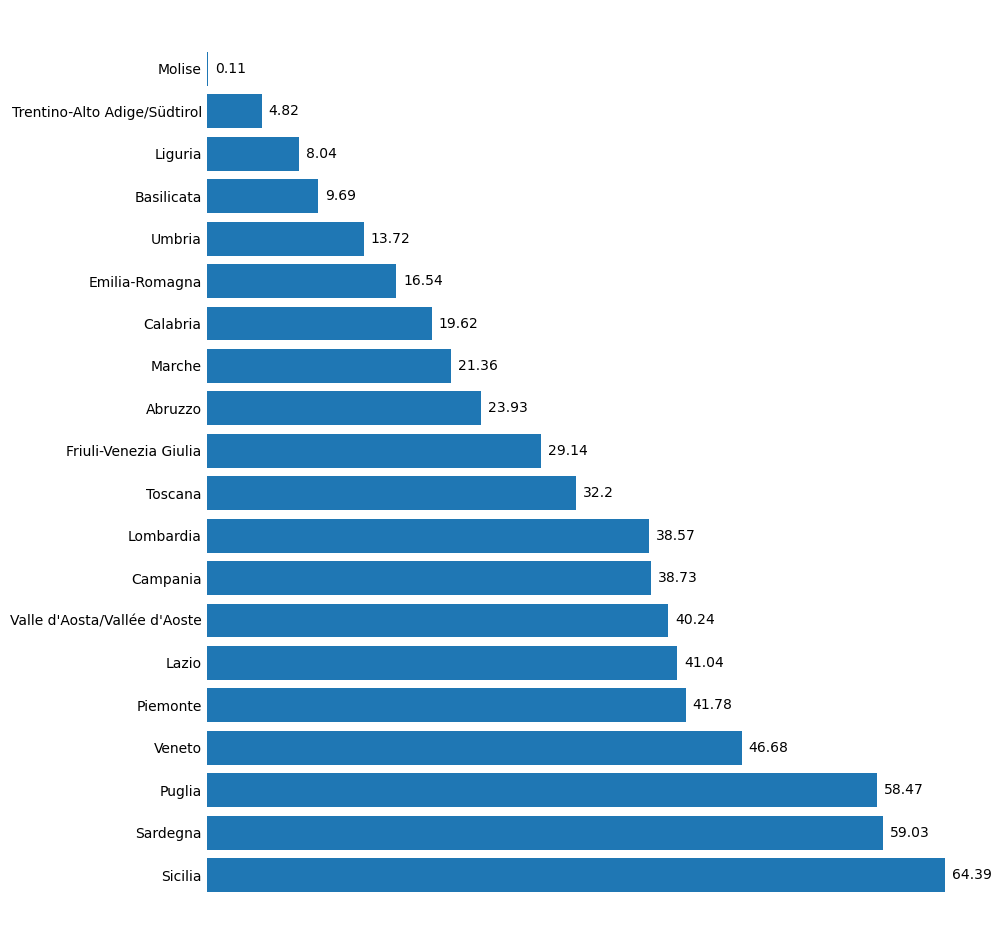

In [19]:
dedicante = pd.DataFrame(chord_relation_percent.sum(axis = 0) - np.diag(chord_relation_percent) * 20).sort_values(by=0, ascending=True)
plot_barh(-dedicante,  figsize=(10, 12))

Text(0.5, 0.98, 'Percentuale di vie intolate a città italiane divise per regione')

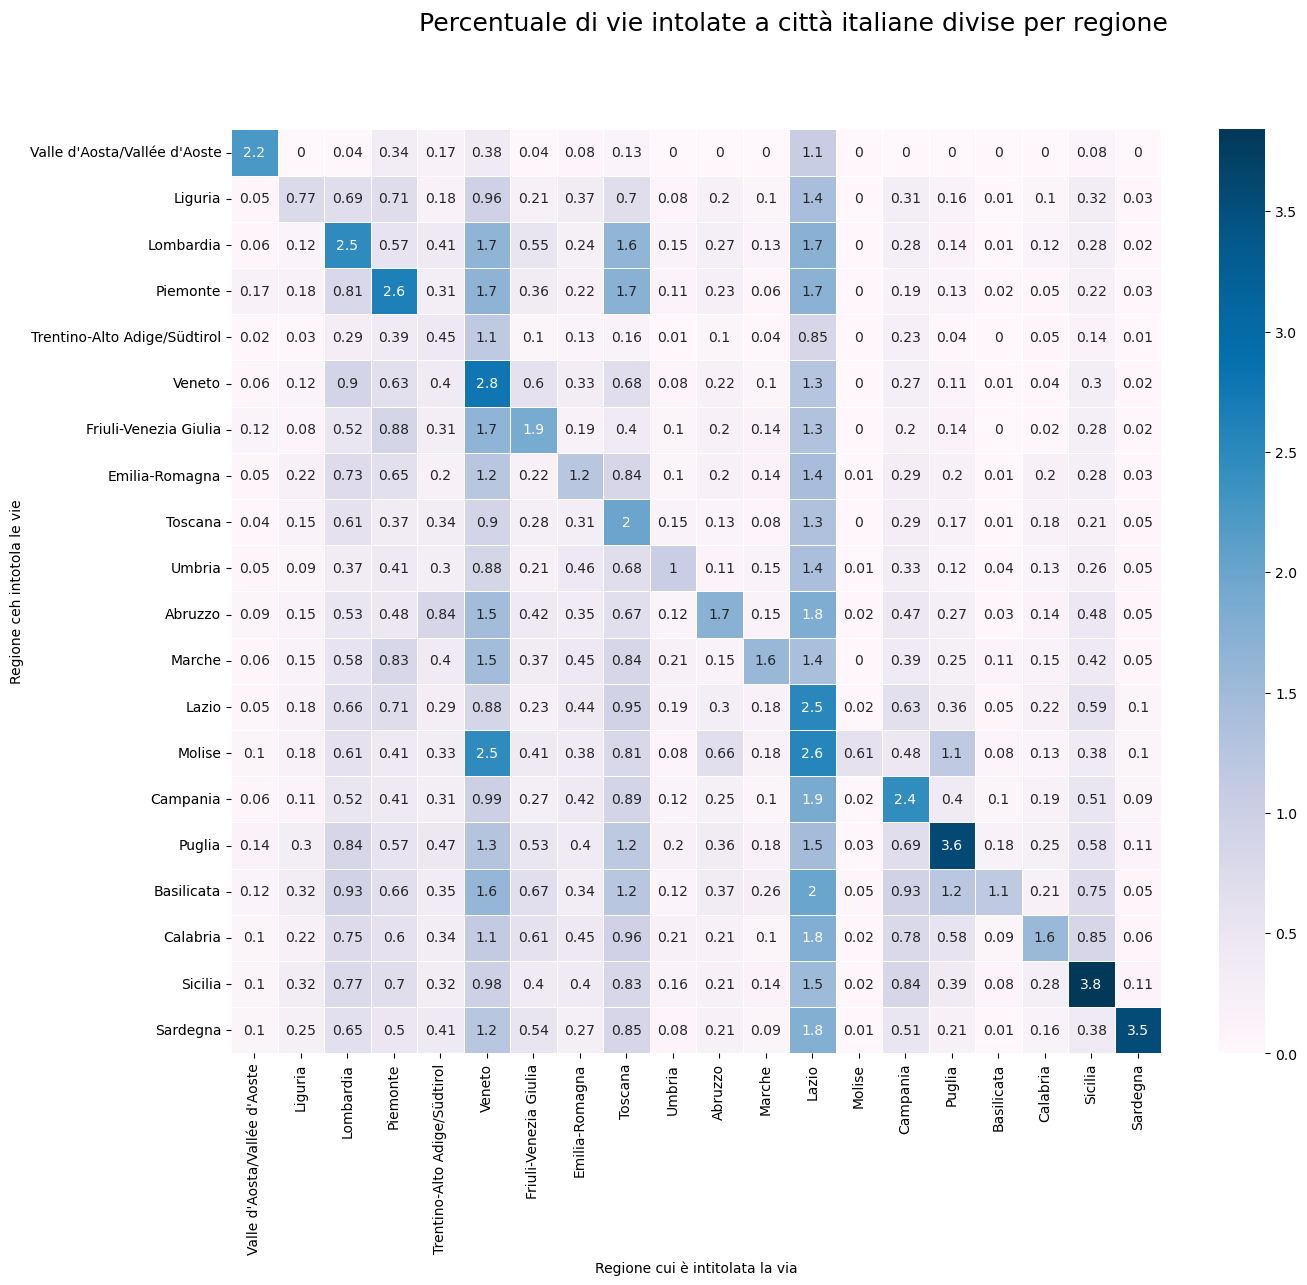

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,12))         # Sample figsize in inches
sns.heatmap(chord_relation_percent.T, annot=True, linewidths=.5, ax=ax, cmap="PuBu")
ax.set(ylabel='Regione ceh intotola le vie', xlabel='Regione cui è intitolata la via')
#fig.suptitle('Percentuale di vie intolate a città italiane')
title_string='Percentuale di vie intolate a città italiane divise per regione'
fig.suptitle(title_string, fontsize=18)
#fig.subtitle(title_string, fontsize=10)

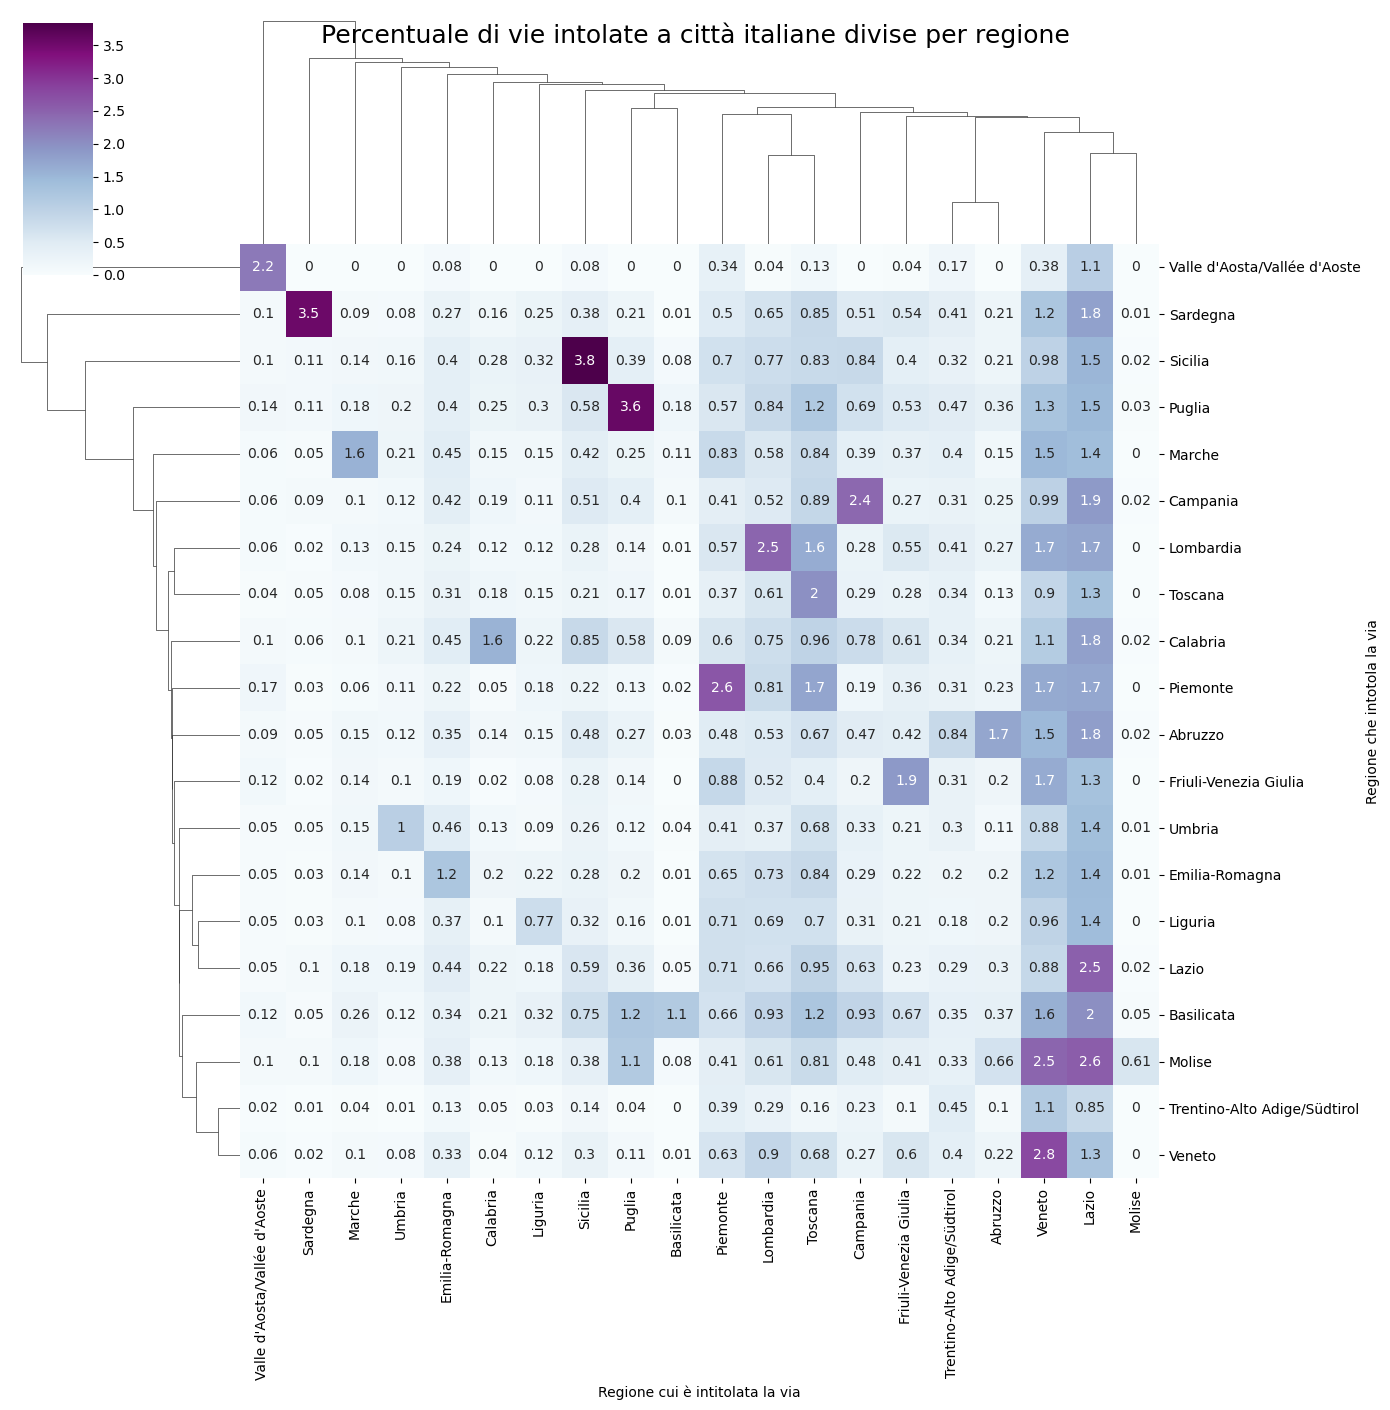

In [23]:
from matplotlib import pyplot as plt

g = sns.clustermap(chord_relation_percent.T, metric="correlation", method="single", cmap="BuPu", annot=True, figsize=(14, 14))
ax = g.ax_heatmap
ax.set(ylabel='Regione che intotola la via', xlabel='Regione cui è intitolata la via')
g.fig.suptitle('Percentuale di vie intolate a città italiane divise per regione', fontsize=18)
g.savefig('./output/correlazione_regioni.png')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
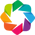

:Chord   [source,target]   (value)

In [34]:
links = chord_relation_count.stack().reset_index()
links.columns = ['source', 'target', 'value']
links

import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)

hv.Chord(links)
chord.opts(opts.Chord(cmap='Category20', edge_cmap='Category20',                              
           edge_color=dim('source').str(), 
           labels='nodes', node_color=dim('index').str()))